In [1]:
import os, sys, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../../modules'))
sys.path.append(os.path.abspath('../../modules/celeba_male'))
import vae_train as vt
import vae_ortho as vo
import vae_surgery as vs
import vae_os as vos
import vae_ascent as va
import vae_ad as vad
import classifier as cl
import batch as bt
import utility as ut
import datapipe
import vae_viz as viz
from vae import VAE


device = ut.get_device()
root = '../../data/CelebA/CelebA-Experiments'
celeba_folder = '../../data/CelebA'
params = {
    "model": f"{celeba_folder}/vae/vae_200.pth",
    "latent_dim": 512,
    "num_steps": 50,
    "batch_size": 128,
    "log_interval": 1,
    "collect_interval": "epoch",
    "save_steps": "epoch",
    "all_classes": [0, 1],
    "forget_class": 1,
    "classifier_path": f"{celeba_folder}/cnn/cnn_10.pth",
    "kl_weight": 1,
    "total_duration": None,
    "data_path": f'{celeba_folder}/dataset',
    "max_data": None
}

[0.6875586873201336, 0.24749456607016201, 0.009370046673697735, 0.9377553102944672]
[3.6625099570669795, 3.490031572447347, 1.680351085506173, 3.718616254260241]


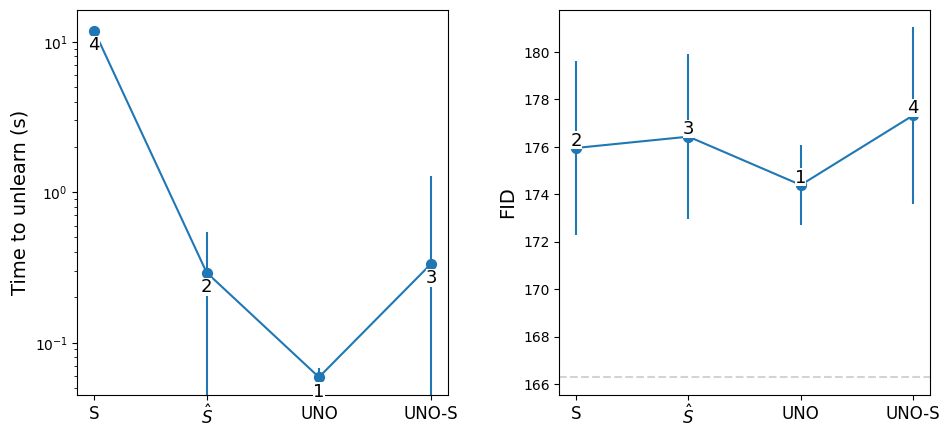

In [2]:
algorithms = {"folders": [], "labels": [], }

# algorithms["folders"].append(f"{root}/vae-a")
# algorithms["labels"].append("A")

# algorithms["folders"].append(f"{root}/vae-ad")
# algorithms["labels"].append("AD")

# algorithms["folders"].append(f"{root}/vae-hat")
# algorithms["labels"].append(r"$\hat{.}$")

algorithms["folders"].append(f"{root}/vae-s")
algorithms["labels"].append("S")

algorithms["folders"].append(f"{root}/vae-shat")
algorithms["labels"].append(r"$\hat{S}$")

algorithms["folders"].append(f"{root}/vae-o")
algorithms["labels"].append(r"UNO")

# algorithms["folders"].append(f"{root}/vae-ohat")
# algorithms["labels"].append(r"$\hat{O}$")

algorithms["folders"].append(f"{root}/vae-os")
algorithms["labels"].append(r"UNO-S")

# algorithms["folders"].append(f"{root}/vae-ohatshat")
# algorithms["labels"].append(r"$\hat{O}\hat{S}$")

bc = bt.BatchCompare(algorithms["folders"], algorithms["labels"])
# bc.plot("8 Fraction", "3 Fraction")
bc.plot2(logs=[True, False], rank=True)
plt.savefig("../../plots/celeba.pdf", bbox_inches="tight")

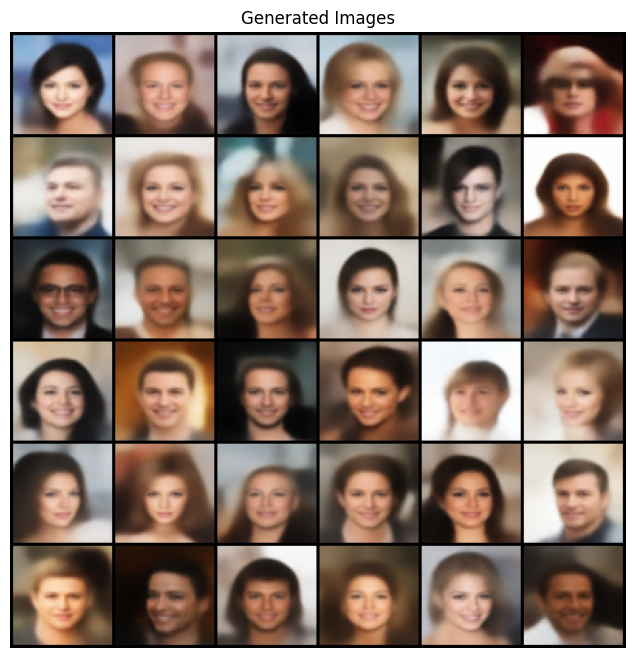

In [14]:
path = "../../data/CelebA/vae/vae_200.pth"
model = vt.init_model(path, 512, 'mps')
viz.generate_random_samples(model, 36);

In [5]:
train_kwargs = params | {"uniformity_weight": 1e3, "orthogonality_weight": 1e3, "forget_weight": 0.}
train_kwargs["folder"] = f"{root}/vae-ohatshat"
be = bt.BatchExperiment(vos.train, train_kwargs, 10)
summary, summary_std = be.summarize_wo_fid()
# be.compute_fid_from_folder(real_images, folder, batch_size=256)
# be.summarize(num_fid_samples=num_fid_samples, batch_size=fid_batch_size)

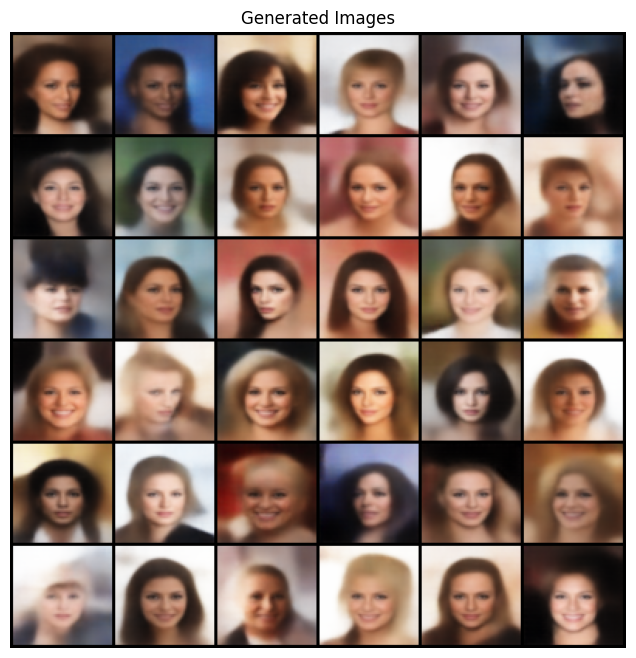

In [2]:
path = "../../data/CelebA/CelebA-Experiments/vae-ohatshat/expr-0/checkpoints/vae_epoch_1.pth"
model = vt.init_model(path, 512, 'mps')
viz.generate_random_samples(model, 36);

**Transformation**

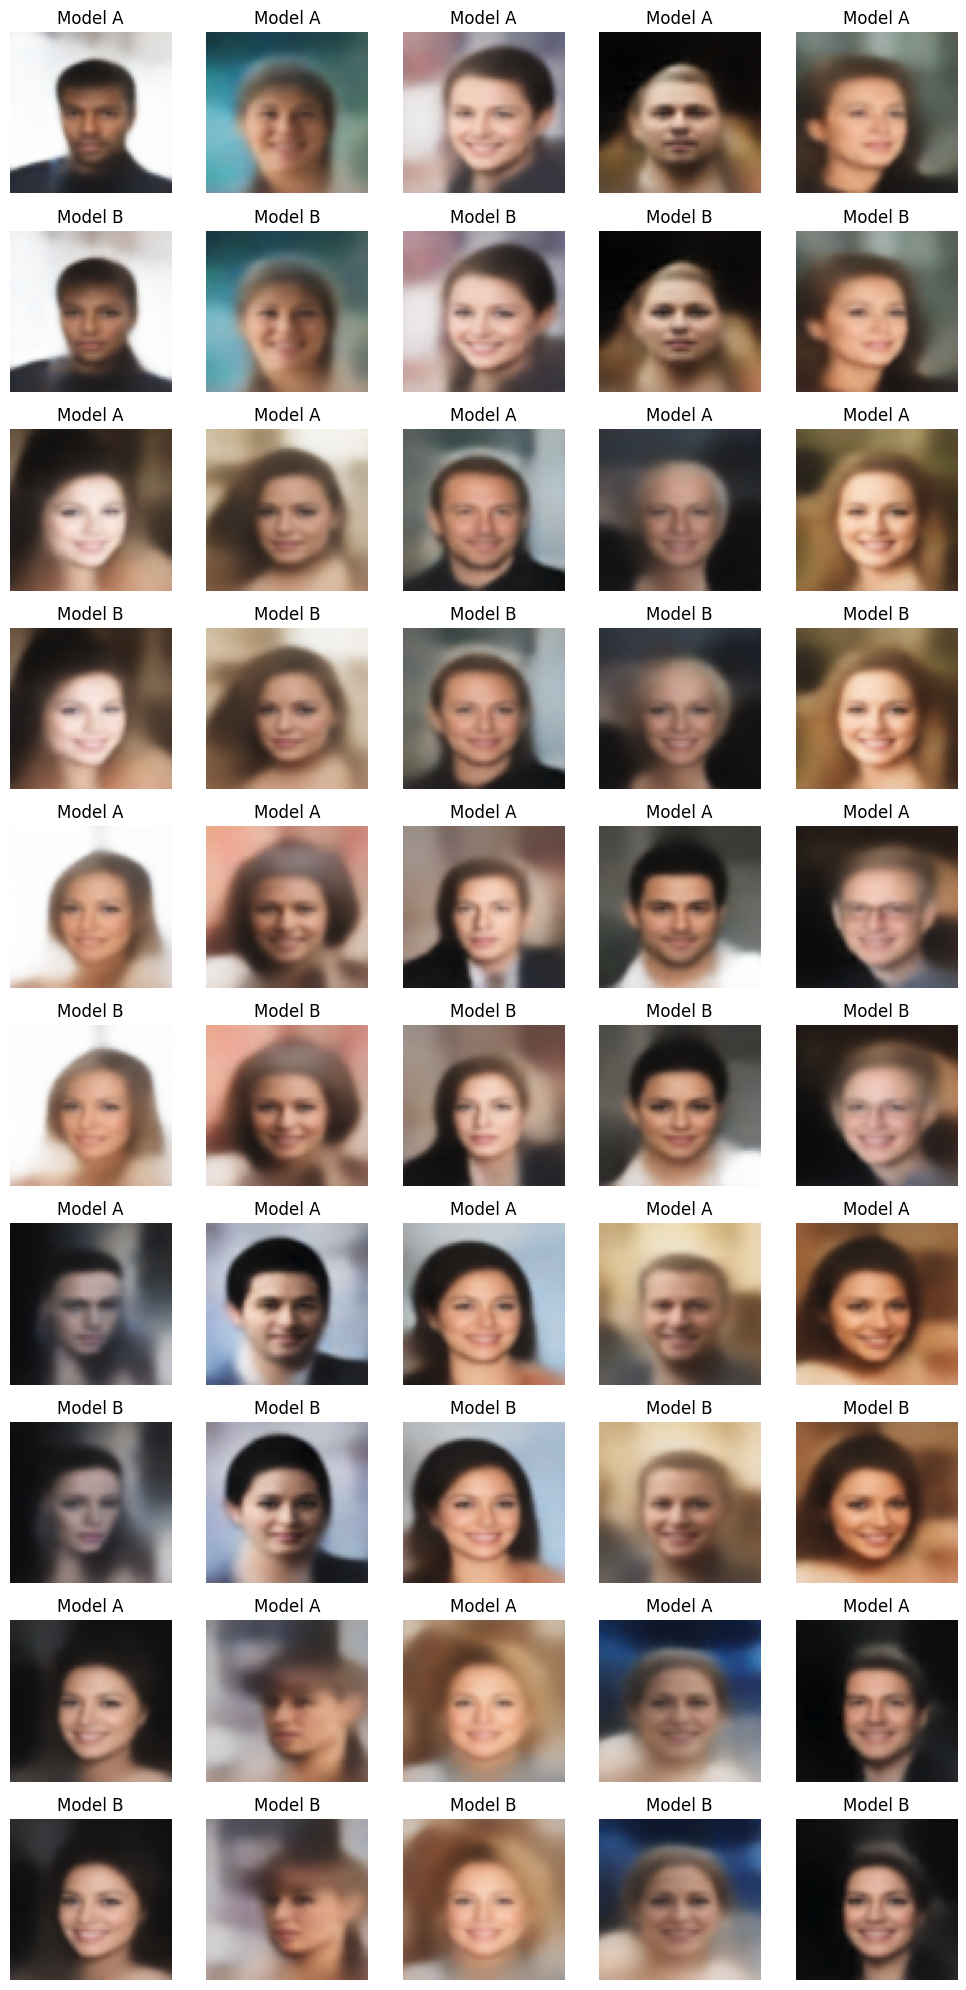

In [7]:
path_a = f'{celeba_folder}/vae/vae_200.pth'
path_b = f'{root}/vae-o/expr-0/checkpoints/vae_epoch_1.pth'
model_a = vt.init_model(path_a, 512, 'mps')
model_b = vt.init_model(path_b, 512, 'mps')
viz.compare_model_outputs(model_a, model_b);

**New sample generation**

Closest index: 111066


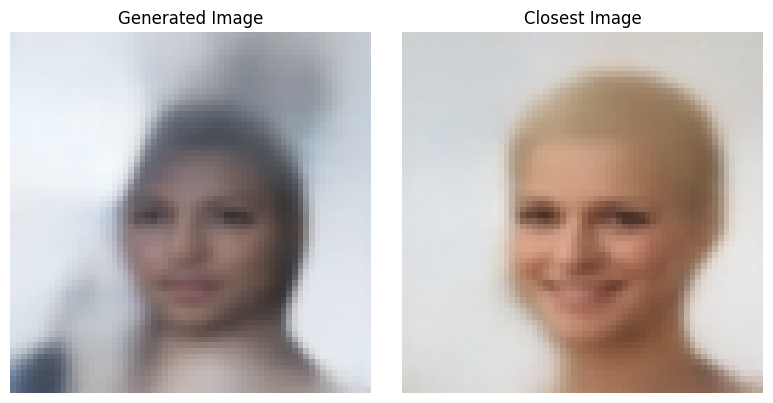

111066

In [35]:
from PIL import Image

def find_closest_image_in_dataset(model, feature_path='../../data/CelebA/vae/features_200.npy',\
    image_dir='../../data/CelebA/dataset-reconstructed/img_align_celeba_reconstructed'):
    device = next(model.parameters()).device
    features = torch.tensor(np.load(feature_path)).to(device)
    features = features.view(features.shape[0], -1)
    model.eval()

    # Generate an image
    gen_img = model.decode(torch.randn(1, 512).to(device))
    # print("Generated image shape:", gen_img.shape)

    # Encode the generated image to get its features
    feat = model.encoder(gen_img)
    feat = feat.view(feat.shape[0], -1)  # Shape: (1, feature_dim)
    # print("Generated feature shape:", feat.shape, "Dataset feature shape:", features.shape)

    # Compute distances
    dists = torch.norm(features - feat, dim=1)  # Euclidean distance
    closest_idx = torch.argmin(dists).item()
    print("Closest index:", closest_idx)

    # Load the closest image from disk
    filename = f"{closest_idx + 1:06d}.jpg"  # zero-padded to 6 digits
    img_path = os.path.join(image_dir, filename)
    closest_img = Image.open(img_path).convert("RGB")
    
    # Plot the generated and closest image
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    gen_img_np = gen_img.squeeze().detach().cpu().numpy()

    if gen_img_np.ndim == 3:
        gen_img_np = np.transpose(gen_img_np, (1, 2, 0))  # C, H, W -> H, W, C
        # closest_img_np = np.transpose(closest_img_np, (1, 2, 0))

    axes[0].imshow(gen_img_np.clip(0, 1))
    axes[0].set_title("Generated Image")
    axes[0].axis("off")

    axes[1].imshow(closest_img)
    axes[1].set_title("Closest Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    return closest_idx


find_closest_image_in_dataset(model_a)